In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
names = ['vert_index_0', 'x', 'y', 'z', 'is_border', 'vtx_raw', 'vert_index_1']
info = pd.read_csv('../../reference/fsaverage-lh_cortex_flat.csv', header=0, names=names)
info.head()

,vert_index_0,x,y,z,is_border,vtx_raw,vert_index_1
0,0.0,-60.013611,4.446770,0,0,1.0,1.0
1,1.0,-56.163204,88.759064,0,0,2.0,2.0
2,2.0,-112.137077,-18.977211,0,0,3.0,3.0
3,3.0,-34.436668,-72.297958,0,0,4.0,4.0
4,4.0,5.378906,-8.031876,0,0,5.0,5.0


In [3]:
names = ['vert_index_0', 'x', 'y', 'z', 'is_border', 'vtx_raw', 'vert_index_1']
info_right = pd.read_csv('../../reference/fsaverage-rh_cortex_flat.csv', header=0, names=names)

In [4]:
info_right.shape

(149765, 7)

In [5]:
min_x, max_x = info.x.min(), info.x.max()

# Integer Parsing

## without Modification

In [6]:
info_int = pd.DataFrame({
    'idx': info.vert_index_0.astype(int),
    'x'  : info.x.values.astype(int),
    'y'  : info.y.values.astype(int),
})

info_int_right = pd.DataFrame({
    'idx': info_right.vert_index_0.astype(int),
    'x'  : info_right.x.values.astype(int),
    'y'  : info_right.y.values.astype(int),
})

## Double and Parse

In [7]:
info_double = pd.DataFrame({
    'idx': info.vert_index_0.astype(int),
    'x'  : info.x.apply(lambda x: 2*x).values.astype(int),
    'y'  : info.y.apply(lambda x: 2*x).values.astype(int),
})

info_double_right = pd.DataFrame({
    'idx': info_right.vert_index_0.astype(int),
    'x'  : info_right.x.apply(lambda x: 2*x).values.astype(int),
    'y'  : info_right.y.apply(lambda x: 2*x).values.astype(int),
})

## Generalized Dilation

In [8]:
idx = info.vert_index_0.values.astype(int)
lh_features = {
    'area': np.load('../res/full_data_matrix/oasis1&3_ALL_lh_area-fsaverage.npy')[:, idx],
    'curv': np.load('../res/full_data_matrix/oasis1&3_ALL_lh_curv-fsaverage.npy')[:, idx],
    'jacob': np.load('../res/full_data_matrix/oasis1&3_ALL_lh_jacobian_white-fsaverage.npy')[:, idx],
    'sulc': np.load('../res/full_data_matrix/oasis1&3_ALL_lh_sulc-fsaverage.npy')[:, idx],
    'thick': np.load('../res/full_data_matrix/oasis1&3_ALL_lh_thickness-fsaverage.npy')[:, idx],
    'vol': np.load('../res/full_data_matrix/oasis1&3_ALL_lh_volume-fsaverage.npy')[:, idx],
}

In [84]:
area = np.load('../res/full_data_matrix/oasis1&3_ALL_lh_area-fsaverage.npy')

In [87]:
area[1, [1, 2, 3]].mean()

0.4011656666666667

In [89]:
pd.Series({1: [2, 3]})

1    [2, 3]
dtype: object

In [9]:
def dilation_transform(original, dilation=1, features=None, subject=None, dtype=int):

    dilated = pd.DataFrame({
        'idx': original.vert_index_0.astype(int),
        'x': original.x.apply(lambda x: dilation*x).values.astype(dtype),
        'y': original.y.apply(lambda x: dilation*x).values.astype(dtype),
    })

    nodes = set()
    for x, y in zip(dilated.x.values, dilated.y.values):
        tmp = (x, y)
        nodes.add(tmp)

    if features:
        if subject or subject == 0:
            feat = pd.DataFrame(columns=features.keys(), index=list(original.index))
            for name, feature in features.items():
                feat[name] = feature[subject]

            dilated = pd.concat([dilated, feat], axis=1)

        else:
            print("Put in subject #!")
    else:
        pass

    return dilated, nodes

In [10]:
def averaging(dilated, nodes):
    store_idx = dict()
    store_val = dict()
    feat_lst = ['area', 'curv', 'jacob', 'sulc', 'thick', 'vol']
    for i, node in tqdm(enumerate(nodes)):
        x, y = node
        intersect = list(dilated.index[(dilated.x==x) & (dilated.y==y)])
        store_idx[node] = intersect
        
        tmp = []
        for feat in feat_lst:
            tmp.append(dilated.loc[intersect, feat].mean())
        store_val[node] = tmp    
            
    return store_idx, store_val

In [11]:
def convert_image(store_val):
    X = np.array([n[0] for n in store_val.keys()])
    Y = np.array([n[1] for n in store_val.keys()])
    min_x, max_x = X.min(), X.max()
    min_y, max_y = Y.min(), Y.max()
    
    nodes = list(store_val.keys())

    img = np.zeros((max_x - min_x + 1, max_y - min_y + 1, 6))
    for x in tqdm(range(min_x, max_x+1)):
        for y in range(min_y, max_y+1):
            img[x, y, :] = store_val[(x, y)] if (x, y) in nodes else np.array([-20 for _ in range(6)])
    
    return img

In [18]:
left_1, left_1_nodes = dilation_transform(info, dilation=1, features=lh_features, subject=0)

In [82]:
len(left_1_nodes)

59738

In [106]:
g3[1][(-35, 61)]

[0.32535780000000003,
 0.1252334,
 1.5530574000000001,
 8.915532000000002,
 2.2025202,
 0.6142177999999999]

In [19]:
left_1

,idx,x,y,area,curv,jacob,sulc,thick,vol
0,0,-60,4,0.382552,-0.162256,0.948715,-6.495984,1.925652,0.955984
1,1,-56,88,0.338091,-0.245651,0.785565,-5.860199,2.216291,0.920456
2,2,-112,-18,0.311414,0.011543,1.279098,4.467751,2.239614,0.792105
3,3,-34,-72,0.154877,0.080689,0.917379,6.324287,1.622451,0.204646
4,4,5,-8,0.457287,-0.083836,1.107916,-7.254117,2.717105,1.454773
...,...,...,...,...,...,...,...,...,...
149292,163837,105,113,0.585857,0.222108,1.014310,4.723602,2.678560,0.743302
149293,163838,106,112,0.315156,0.210544,1.218856,4.448838,2.420639,0.456207
149294,163839,106,111,0.315156,0.210544,1.218856,4.448838,2.420639,0.456207
149295,163840,106,111,0.560177,0.187912,1.061036,3.694161,2.487129,1.068560


In [20]:
g3 = averaging(left_1, left_1_nodes) 

In [103]:
g3[1]

{(-35, 61): [0.32535780000000003,
  0.1252334,
  1.5530574000000001,
  8.915532000000002,
  2.2025202,
  0.6142177999999999],
 (35, -61): [0.393704, -0.109895, 0.758257, -2.560096, 2.440284, 1.08447],
 (-49, 126): [0.335067, 0.083466, 0.71564, 5.573616, 0.86178, 0.307894],
 (-102, 118): [0.43609849999999994,
  -0.1430745,
  1.2872795,
  -1.6376385,
  2.1753704999999997,
  1.4599905],
 (-116, 5): [0.49423833333333334,
  0.10061500000000001,
  1.0089296666666667,
  3.2382813333333336,
  2.0147743333333334,
  1.0191189999999999],
 (104, 115): [0.4788645,
  0.204032,
  1.2065899999999998,
  4.8118715000000005,
  2.3196275,
  0.656952],
 (67, 137): [0.24548, -0.21823, 1.184742, 0.772489, 2.734141, 1.355943],
 (-90, -42): [0.370361,
  -0.14053966666666665,
  1.2196233333333335,
  -7.913446666666666,
  3.6714673333333336,
  2.5493583333333336],
 (53, 166): [0.9787585000000001,
  -0.1478115,
  0.4801825,
  -6.6176414999999995,
  2.094804,
  2.3543125],
 (90, 42): [0.3827755,
  -0.1360885,
  1.

In [47]:
import sys

In [48]:
sys.getsizeof(img)

5526128

In [25]:
for k, v in g3[1].items():
    if len(v) != 6:
        print(k)

In [26]:
img = convert_image(g3[1])

In [43]:
np.save('test.npy', img)

In [44]:
test = np.load('test.npy')

In [45]:
test

array([[[ 2.76934800e-01, -2.04295000e-01,  1.48681950e+00,
         -6.42987880e+00,  1.94541700e+00,  7.71319200e-01],
        [ 2.80362800e-01, -3.48497600e-01,  2.02231180e+00,
         -7.67797820e+00,  2.25920500e+00,  9.14272800e-01],
        [ 1.89237500e-01, -3.69111667e-01,  2.60997317e+00,
         -7.82329117e+00,  2.38446650e+00,  8.54924333e-01],
        ...,
        [ 4.42220000e-01,  1.47709625e-01,  9.89689375e-01,
         -3.49513662e+00,  2.80285050e+00,  1.01275713e+00],
        [ 4.82060500e-01,  1.01662000e-01,  1.00958075e+00,
         -3.90544575e+00,  2.49482325e+00,  1.01123250e+00],
        [ 3.84048000e-01, -3.71742857e-03,  1.12130443e+00,
         -5.02712357e+00,  1.95907200e+00,  7.16582286e-01]],

       [[ 3.99549857e-01, -1.39956714e-01,  1.02163457e+00,
         -7.36810143e+00,  2.13728471e+00,  1.09631257e+00],
        [ 3.88246333e-01, -2.12827000e-01,  1.02233167e+00,
         -8.34822033e+00,  2.67215933e+00,  1.32687800e+00],
        [ 4.57726

In [30]:
lh_features['area'].shape

(867, 149297)

In [28]:
img

array([[[ 2.76934800e-01, -2.04295000e-01,  1.48681950e+00,
         -6.42987880e+00,  1.94541700e+00,  7.71319200e-01],
        [ 2.80362800e-01, -3.48497600e-01,  2.02231180e+00,
         -7.67797820e+00,  2.25920500e+00,  9.14272800e-01],
        [ 1.89237500e-01, -3.69111667e-01,  2.60997317e+00,
         -7.82329117e+00,  2.38446650e+00,  8.54924333e-01],
        ...,
        [ 4.42220000e-01,  1.47709625e-01,  9.89689375e-01,
         -3.49513662e+00,  2.80285050e+00,  1.01275713e+00],
        [ 4.82060500e-01,  1.01662000e-01,  1.00958075e+00,
         -3.90544575e+00,  2.49482325e+00,  1.01123250e+00],
        [ 3.84048000e-01, -3.71742857e-03,  1.12130443e+00,
         -5.02712357e+00,  1.95907200e+00,  7.16582286e-01]],

       [[ 3.99549857e-01, -1.39956714e-01,  1.02163457e+00,
         -7.36810143e+00,  2.13728471e+00,  1.09631257e+00],
        [ 3.88246333e-01, -2.12827000e-01,  1.02233167e+00,
         -8.34822033e+00,  2.67215933e+00,  1.32687800e+00],
        [ 4.57726

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(6, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))

In [33]:
cnn = Model()

In [41]:
cnn.forward(tensor_img)

tensor([[[[1.9947, 1.9657, 2.2380,  ..., 2.9925, 2.7258, 2.6269],
          [2.6049, 2.9633, 2.7190,  ..., 2.8266, 2.0626, 2.6266],
          [2.5822, 2.6001, 2.0779,  ..., 0.9841, 0.6061, 0.6614],
          ...,
          [2.2269, 2.6661, 2.8233,  ..., 2.0577, 2.3915, 2.2771],
          [3.1209, 1.9501, 2.3388,  ..., 3.3106, 3.0254, 3.4717],
          [3.0896, 4.2093, 3.6040,  ..., 2.1178, 1.4292, 1.1974]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.5842, 1.0704, 2.1148],
          [0.9573, 1.1459, 1.3239,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [3.1805, 2.9855, 4.0660,  ..., 1.5550, 1.2127, 1.0234],
          [0.6148, 0.3972, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 2.0031, 1.9599, 2.0987]],

         [[0.8035, 0.9828, 0.5914,  ..., 0.1178, 0.6457, 0.3795],
          [0.3817, 0.3271, 0.7932,  ..., 0.0000, 0.0000, 0.0000],
          [0.1905, 0.0000, 0.0000,  ..., 0

In [39]:
tensor_img = torch.tensor(img.reshape(1, 6, 307, 375), dtype=torch.float)

# Draw Converted 2D Brain

In [143]:
sample = np.load('../res/npy_img/0.npy')
sample.shape

(307, 375, 6)

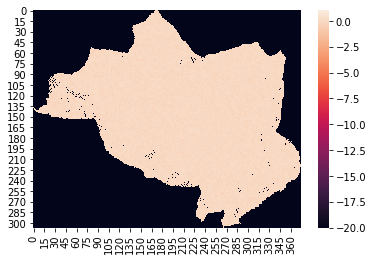

In [144]:
draw = sample[:, :, 1]
import seaborn as sns
sns.heatmap(draw)